
`gwf` workflow for creating .scool files from single-cell Hi-C pairs
of sperm samples, originating from DOI 10.1038/s41467-025-59055-z.
Matrices are separated based on metadata sheet defining the X/Y haplotype —
(Supplementary Table 1).


How to run:
conda activate hic
gwf -f master_workflow.py status

Pipeline:
0: Process the metadata sheet to create a list of samples and grouping (Pandas) 
1: Create .cool files from all single cells (including balancing)
2: Create .scool files from all .cool files


In [34]:
from gwf import Workflow, AnonymousTarget
import os
import subprocess
import os.path as op
import pandas as pd
from glob import glob
from cooler.fileops import list_coolers
from pprintpp import pprint as pp

In [35]:
# Create a workflow object
gwf = Workflow(defaults={'nodes': 1, 'queue':"normal", 'account':"hic-spermatogenesis"})

## Target Template functions

### Create .cool files from grouped single-cell Hi-C pairs


In [36]:
# Template for creating .cool files from pairs
def pairs2cool(chromsizes, pairs, cooler):
    """
    Template to create a .cool file from pairs.
    
    Parameters:
    - pairs: Path to the input pairs file.
    - cooler: Path where the output .cool file will be saved.
    - chromsizes: Path to the chromosome sizes file.
    - balanced: Whether to balance the matrix or not.
    """
    inputs = {'chromsizes': chromsizes, 
              'pairs': pairs}
    outputs = {'cooler': cooler}
    options = {
        'memory': '4g',
        'walltime': '00:10:00',
        'cores': 1 
    }
    spec = f"""
source $(conda info --base)/etc/profile.d/conda.sh
conda activate hic
cooler cload pairs \
    -c1 2 -p1 3 -c2 4 -p2 5 \
    --assembly 'GRCh38' \
    --chunksize 200000 \
    {inputs[chromsizes]}:1000 \
    {inputs[pairs]} \
    {outputs[cooler]}
"""
    return AnonymousTarget(
    name=f"pairs2cool_{op.basename(cooler).split('.')[0]}",
    inputs=inputs,
    outputs=outputs,
    options=options,
    spec=spec
    )

### Create .scool files from .cool files

## Grouping


## GRCh38 chromosome sizes

In [37]:
chromsizes = "supplementary/GRCh38.chrom.sizes"

### Process metadata sheet

In [38]:
meta = pd.read_excel("supplementary/41467_2025_59055_MOESM4_ESM.xlsx", sheet_name=0)

print(f"Shape: {meta.shape}")
meta.head()

Shape: (2146, 11)


Cell name    Cell type       Species Sample origin  Raw reads  Raw contacts  \
0       HS1  Sperm cells  Homo sapiens       Donor 1    8538620        369495   
1       HS2  Sperm cells  Homo sapiens       Donor 1    5730666        288202   
2       HS3  Sperm cells  Homo sapiens       Donor 1    6401230        275140   
3       HS4  Sperm cells  Homo sapiens       Donor 1    9764706        581577   
4       HS5  Sperm cells  Homo sapiens       Donor 1    4647864           167   

   Clean contacts  QC passed  Structure valid X/Y sample (haploid only)  \
0          147794       True             True                         X   
1          134679       True             True                         X   
2          114854       True             True                         X   
3          198769       True             True                         Y   
4               0      False            False                       NaN   

   RMSD 20k  
0  0.253343  
1  0.319888  
2  0.362681  
3  0.348015  
4       NaN

In [39]:
# Rename columns for easier access

meta.rename(columns={
    "Cell name": "name", 
    "QC passed": "qc_passed",
    "Structure valid": "structure_valid",
    "X/Y sample (haploid only)": "sex_chrom"
}, inplace=True)
meta.head()

name    Cell type       Species Sample origin  Raw reads  Raw contacts  \
0  HS1  Sperm cells  Homo sapiens       Donor 1    8538620        369495   
1  HS2  Sperm cells  Homo sapiens       Donor 1    5730666        288202   
2  HS3  Sperm cells  Homo sapiens       Donor 1    6401230        275140   
3  HS4  Sperm cells  Homo sapiens       Donor 1    9764706        581577   
4  HS5  Sperm cells  Homo sapiens       Donor 1    4647864           167   

   Clean contacts  qc_passed  structure_valid sex_chrom  RMSD 20k  
0          147794       True             True         X  0.253343  
1          134679       True             True         X  0.319888  
2          114854       True             True         X  0.362681  
3          198769       True             True         Y  0.348015  
4               0      False            False       NaN       NaN

In [40]:
# Queries
human = "Species == 'Homo sapiens'"
qc_passed = "qc_passed == True"
structure_valid = "structure_valid == True"
x_y_assigned = "sex_chrom.isin(['X', 'Y'])"

# Filter metadata
valid = meta.query(f"{human} & {qc_passed} & {structure_valid} & {x_y_assigned}")
valid.groupby("sex_chrom").size()


sex_chrom
X    535
Y    449
dtype: int64

In [41]:
valid.query("sex_chrom == 'X'")

name    Cell type       Species Sample origin  Raw reads  Raw contacts  \
0       HS1  Sperm cells  Homo sapiens       Donor 1    8538620        369495   
1       HS2  Sperm cells  Homo sapiens       Donor 1    5730666        288202   
2       HS3  Sperm cells  Homo sapiens       Donor 1    6401230        275140   
6       HS7  Sperm cells  Homo sapiens       Donor 1    4711760        300416   
8     HS497  Sperm cells  Homo sapiens       Donor 1    7815454        385924   
...     ...          ...           ...           ...        ...           ...   
1036  HS490  Sperm cells  Homo sapiens       Donor 2    7197914        460505   
1037  HS491  Sperm cells  Homo sapiens       Donor 2    7008416        341385   
1038  HS492  Sperm cells  Homo sapiens       Donor 2   15114614        547587   
1040  HS495  Sperm cells  Homo sapiens       Donor 2    4862924        223842   
1041  HS496  Sperm cells  Homo sapiens       Donor 2    7471024        424217   

      Clean contacts  qc_passed  structure_valid sex_chrom  RMSD 20k  
0             147794       True             True         X  0.253343  
1             134679       True             True         X  0.319888  
2             114854       True             True         X  0.362681  
6             148051       True             True         X  0.247536  
8             200515       True             True         X  0.258691  
...              ...        ...              ...       ...       ...  
1036          210615       True             True         X  0.251434  
1037          182949       True             True         X  0.250704  
1038          152495       True             True         X  0.235510  
1040          140951       True             True         X  0.371921  
1041          210426       True             True         X  0.231883  

[535 rows x 11 columns]

In [42]:
# Create lists of names

x_names = valid.query("sex_chrom == 'X'")["name"].tolist()
y_names = valid.query("sex_chrom == 'Y'")["name"].tolist()

In [43]:
filenames = pd.Series([os.path.basename(file) for file in glob("pairs/*")])

pairs = pd.DataFrame({'path':filenames})
pairs[['GSM', 'name']] = filenames.str.split("_", expand=True)
pairs[['name', 'ext']] = pairs['name'].str.split('.',n=1, expand=True)

# Finally, filter the valid samples again
pairs = pairs.query("name in @valid.name")
pairs = pairs.merge(valid[['name','sex_chrom']], on='name', how='inner', )
pairs['cool_out'] = pairs.apply(lambda row: f"coolers/{row['sex_chrom']}/{row['name']}", axis=1)
pairs

path         GSM   name       ext sex_chrom  \
0    GSM8511034_HS384.pairs.gz  GSM8511034  HS384  pairs.gz         X   
1     GSM8510938_HS95.pairs.gz  GSM8510938   HS95  pairs.gz         X   
2     GSM8510913_HS21.pairs.gz  GSM8510913   HS21  pairs.gz         Y   
3    GSM8511129_HS669.pairs.gz  GSM8511129  HS669  pairs.gz         X   
4    GSM8511120_HS641.pairs.gz  GSM8511120  HS641  pairs.gz         X   
..                         ...         ...    ...       ...       ...   
979  GSM8511025_HS355.pairs.gz  GSM8511025  HS355  pairs.gz         Y   
980  GSM8511238_HS995.pairs.gz  GSM8511238  HS995  pairs.gz         X   
981  GSM8511194_HS863.pairs.gz  GSM8511194  HS863  pairs.gz         Y   
982  GSM8511137_HS693.pairs.gz  GSM8511137  HS693  pairs.gz         Y   
983  GSM8511184_HS833.pairs.gz  GSM8511184  HS833  pairs.gz         X   

            cool_out  
0    coolers/X/HS384  
1     coolers/X/HS95  
2     coolers/Y/HS21  
3    coolers/X/HS669  
4    coolers/X/HS641  
..               ...  
979  coolers/Y/HS355  
980  coolers/X/HS995  
981  coolers/Y/HS863  
982  coolers/Y/HS693  
983  coolers/X/HS833  

[984 rows x 6 columns]

In [44]:
for chrom in ['X', 'Y']:
    for row in pairs.query("sex_chrom == @chrom").itertuples():
        print(row)
        # pairs_file = row['path']
        # sample_name = row['name']
        # cooler = f"coolers/{chrom}/{sample_name}.cool"
        
        # print(cooler)
        break

Pandas(Index=0, path='GSM8511034_HS384.pairs.gz', GSM='GSM8511034', name='HS384', ext='pairs.gz', sex_chrom='X', cool_out='coolers/X/HS384')
Pandas(Index=2, path='GSM8510913_HS21.pairs.gz', GSM='GSM8510913', name='HS21', ext='pairs.gz', sex_chrom='Y', cool_out='coolers/Y/HS21')


In [70]:
pairs.filter(['path', 'name', 'sex_chrom', 'cool_out'])[:1].to_dict(orient='records')

[{'path': 'GSM8511034_HS384.pairs.gz',
  'name': 'HS384',
  'sex_chrom': 'X',
  'cool_out': 'coolers/X/HS384'}]

In [ ]:
import cooler
import matplotlib.pyplot as plt
import cooltools.lib.plotting
from matplotlib.colors import LogNorm

clr_X = cooler.Cooler("sperm_X.merged.mcool::resolutions/100000")
clr_X.info

{'bin-size': 100000,
 'bin-type': 'fixed',
 'creation-date': '2025-06-20T10:33:35.958767',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.10.2',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 31134,
 'nchroms': 194,
 'nnz': 47688802,
 'storage-mode': 'symmetric-upper',
 'sum': 94109833}

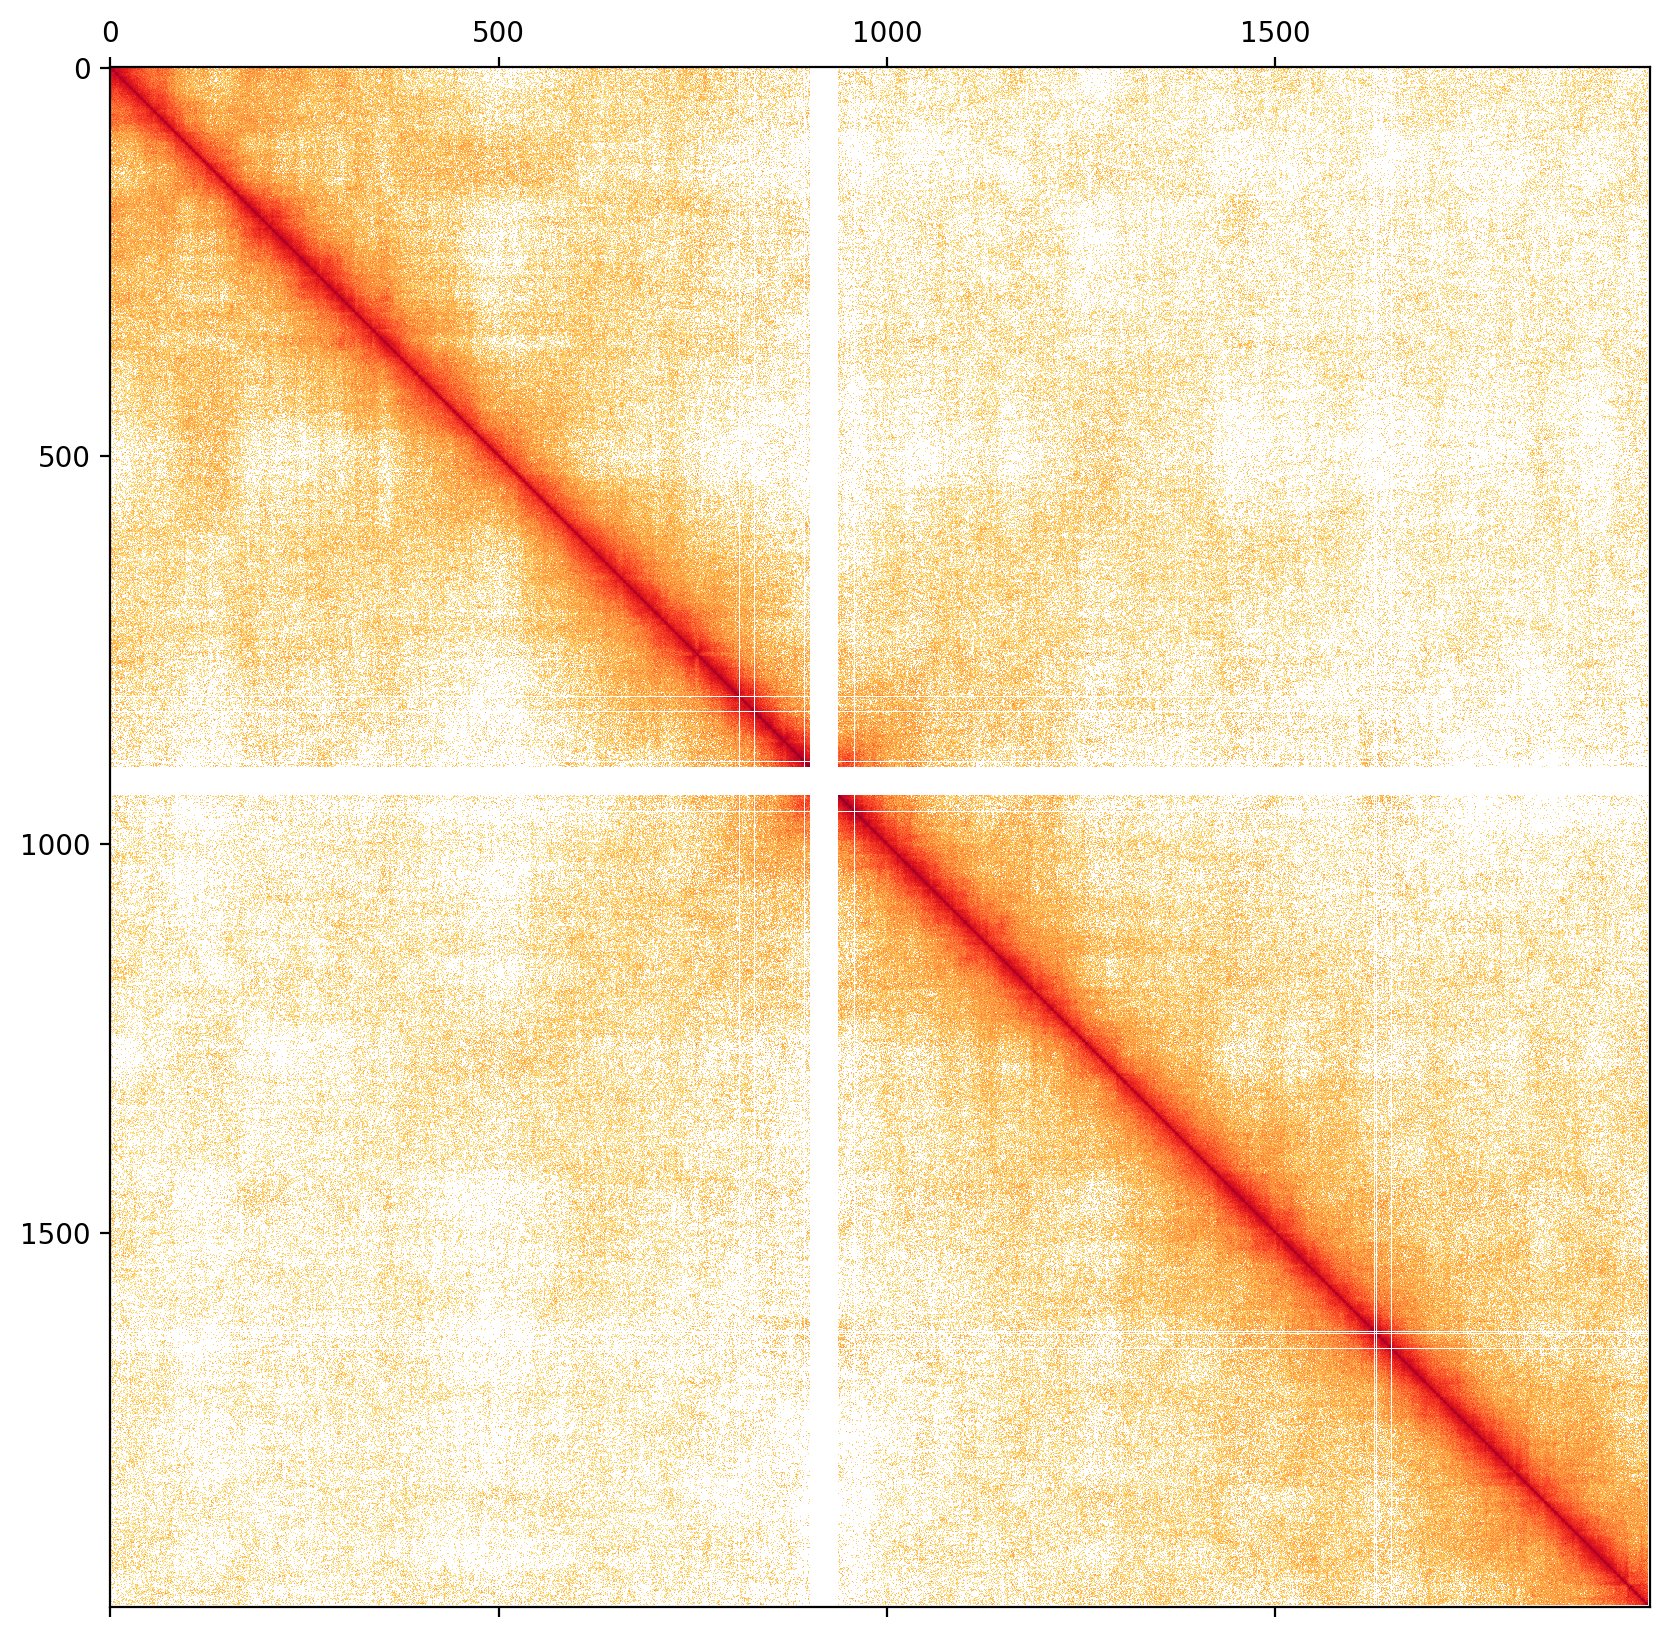

In [30]:
f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmin=1e-5,vmax = 0.1)

im = ax.matshow(
    clr_X.matrix().fetch('chr3'),
    norm=norm,
    cmap='fall'
);

In [ ]:
clr_Y = cooler.Cooler("sperm_Y.merged.mcool::resolutions/100000")
clr_Y.info

{'bin-size': 100000,
 'bin-type': 'fixed',
 'creation-date': '2025-06-20T10:32:40.894779',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.10.2',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 31134,
 'nchroms': 194,
 'nnz': 40290758,
 'storage-mode': 'symmetric-upper',
 'sum': 77836378}

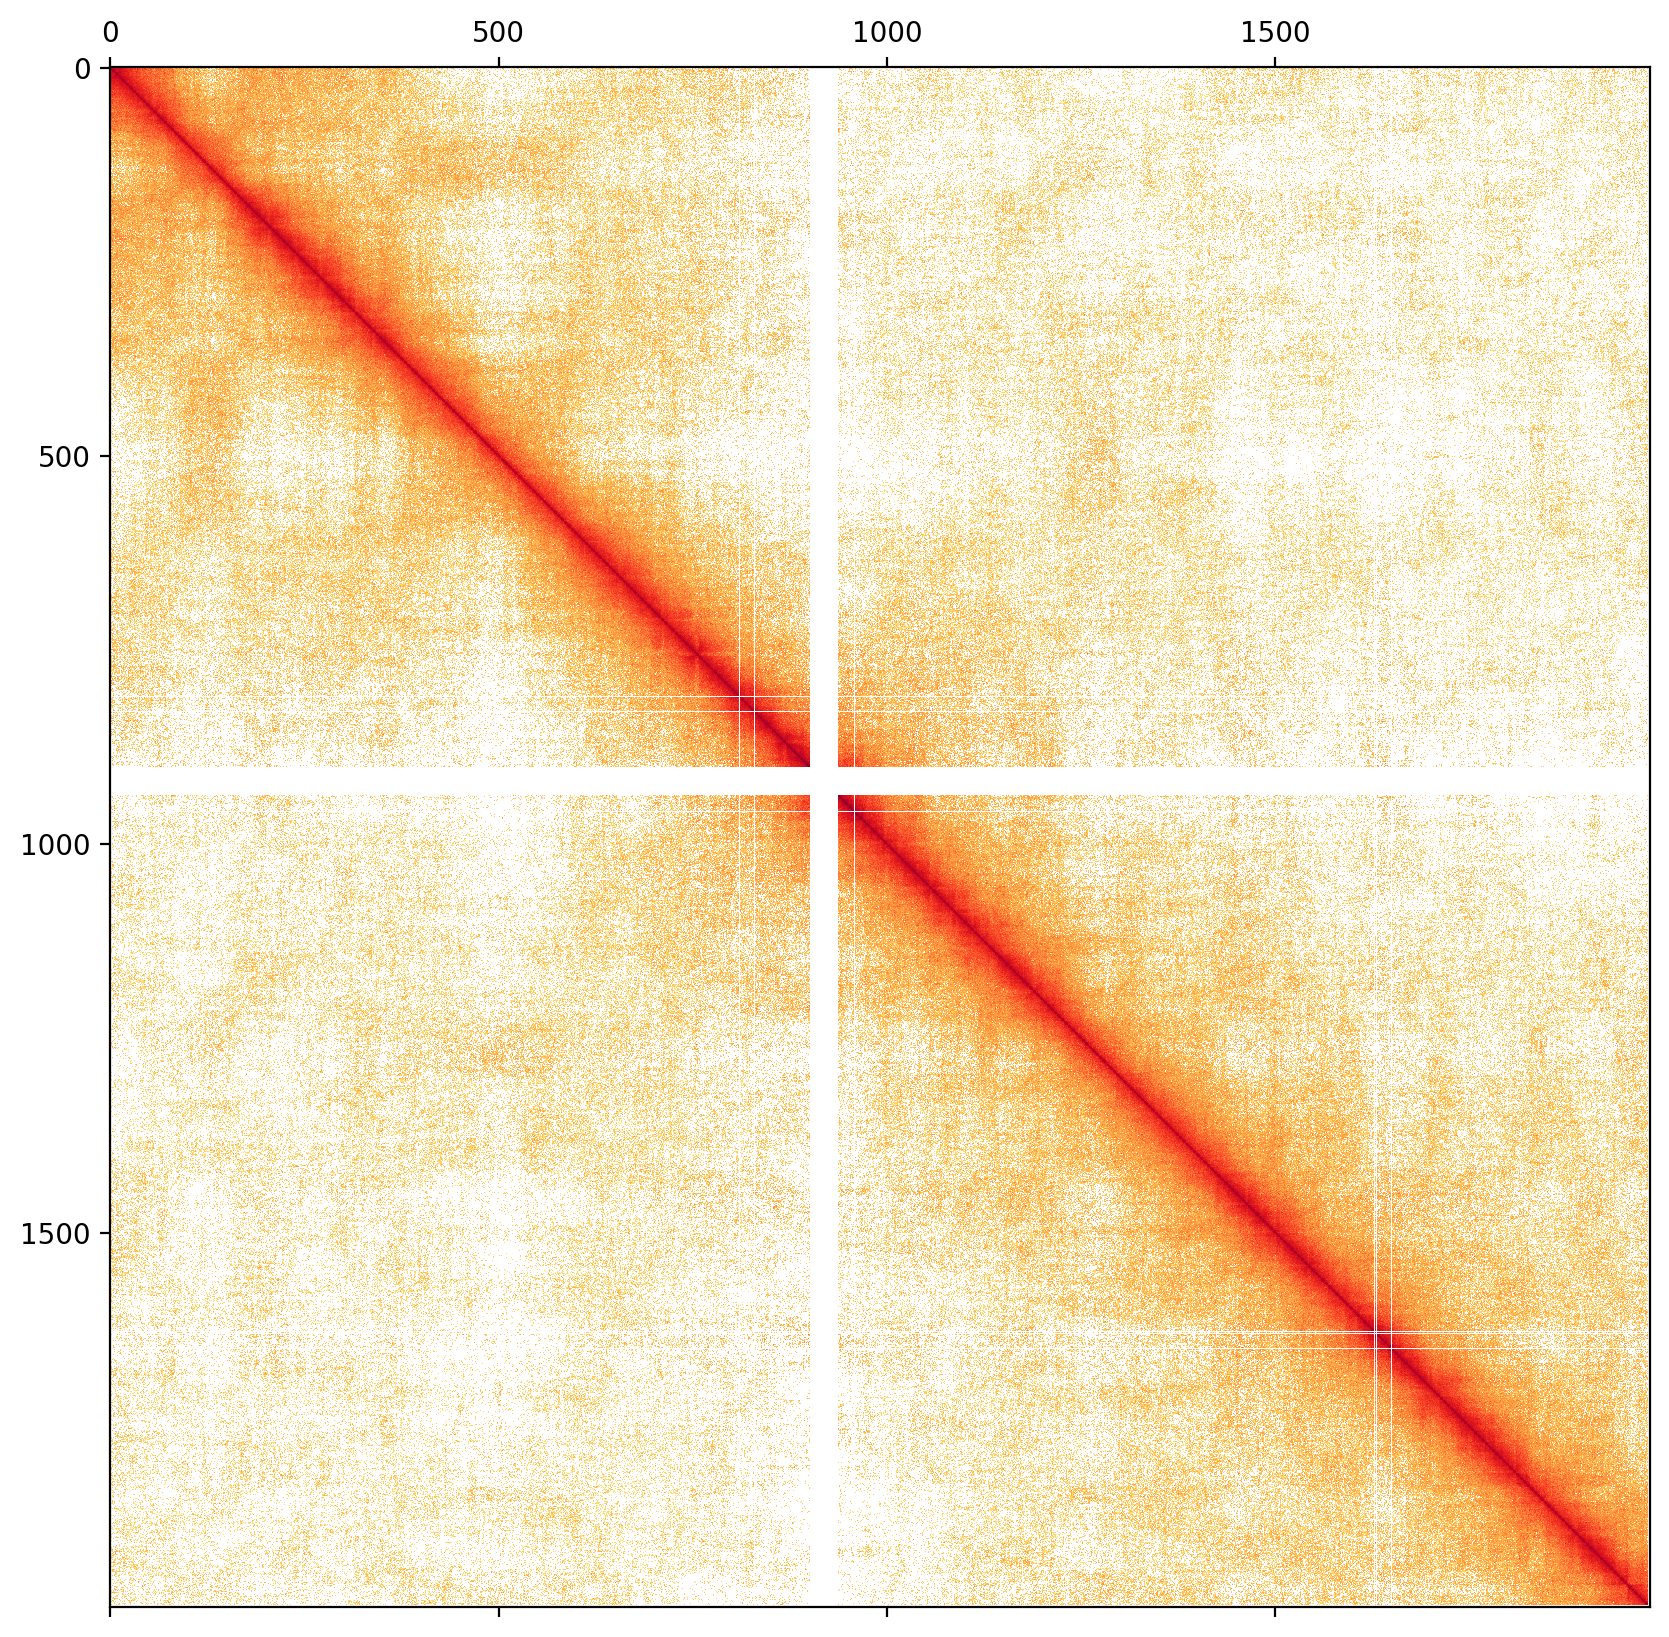

In [32]:
f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmin=1e-5,vmax = 0.1)

im = ax.matshow(
    clr_Y.matrix().fetch('chr3'),
    norm=norm,
    cmap='fall'
);